### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [4]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

<IPython.core.display.Javascript object>

In [5]:
dataset = datasets.ImageFolder("Dataset", transform=transform)

<IPython.core.display.Javascript object>

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root Location: Dataset
    Transforms (if any): Compose(
                             Resize(size=255, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                         )
    Target Transforms (if any): None

<IPython.core.display.Javascript object>

In [7]:
indices = list(range(len(dataset)))

<IPython.core.display.Javascript object>

In [8]:
split = int(np.floor(0.8 * len(dataset)))  # train_size

<IPython.core.display.Javascript object>

In [9]:
np.random.shuffle(indices)

<IPython.core.display.Javascript object>

### Split into Train and Test

In [10]:
train_indices, test_indices = indices[:split], indices[split:]

<IPython.core.display.Javascript object>

In [11]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

<IPython.core.display.Javascript object>

In [12]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)

<IPython.core.display.Javascript object>

In [13]:
targets_size = len(dataset.class_to_idx)

<IPython.core.display.Javascript object>

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

<center><b>Shape on Each Layer</b><br><img src='image2.jpg' style="width:300px;height:500px;"></center>

In [14]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1
        )

        self.max_pool1 = nn.MaxPool2d(2, 2)

        self.conv_layer2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1
        )

        self.max_pool2 = nn.MaxPool2d(2, 2)

        self.conv_layer3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1
        )

        self.max_pool3 = nn.MaxPool2d(2, 2)

        self.conv_layer4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1
        )

        self.max_pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(12 * 12 * 256, 1024)
        self.fc2 = nn.Linear(1024, K)

    def forward(self, X):
        x = F.relu(self.conv_layer1(X))
        x = self.max_pool1(x)
        x = F.relu(self.conv_layer2(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv_layer3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv_layer4(x))
        x = self.max_pool4(x)
        # Flatten
        x = x.view(-1, 256 * 12 * 12)

        # Fully connected
        x = F.dropout(x, p=0.5)
        x = self.fc1(x)
        x = F.dropout(x, p=0.5)
        out = self.fc2(x)

        return out

<IPython.core.display.Javascript object>

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


<IPython.core.display.Javascript object>

In [18]:
model = CNN(targets_size)

<IPython.core.display.Javascript object>

In [19]:
model.to(device)

CNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=39, bias=True)
)

<IPython.core.display.Javascript object>

In [20]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
         MaxPool2d-2         [-1, 32, 111, 111]               0
            Conv2d-3         [-1, 64, 109, 109]          18,496
         MaxPool2d-4           [-1, 64, 54, 54]               0
            Conv2d-5          [-1, 128, 52, 52]          73,856
         MaxPool2d-6          [-1, 128, 26, 26]               0
            Conv2d-7          [-1, 256, 24, 24]         295,168
         MaxPool2d-8          [-1, 256, 12, 12]               0
            Linear-9                 [-1, 1024]      37,749,760
           Linear-10                   [-1, 39]          39,975
Total params: 38,178,151
Trainable params: 38,178,151
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 26.98
Params size (MB): 145.64
Es

<IPython.core.display.Javascript object>

In [21]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

<IPython.core.display.Javascript object>

### Batch Gradient Descent

In [22]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        test_loss = []

        for inputs, targets in test_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            test_loss.append(loss.item())  # torch to numpy world

        test_loss = np.mean(test_loss)

        train_losses[e] = train_loss
        test_losses[e] = test_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{test_loss:.3f} Duration:{dt}"
        )

    return train_losses, test_losses

<IPython.core.display.Javascript object>

In [23]:
# train_losses, test_losses = batch_gd(model, criterion, train_loader, test_loader, 5)

<IPython.core.display.Javascript object>

### Save the Model

In [24]:
torch.save(model.state_dict() , 'new_Model.pt')

<IPython.core.display.Javascript object>

### Load Model

In [25]:
model = CNN(targets_size)
model.load_state_dict(torch.load("new_Model.pt"))
model.eval()

CNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=39, bias=True)
)

<IPython.core.display.Javascript object>

In [26]:
# %matplotlib notebook

<IPython.core.display.Javascript object>

### Plot the loss

In [27]:
# plt.plot(train_losses , label = 'train_loss')
# plt.plot(test_losses , label = 'test_loss')
# plt.legend()
# plt.show()

<IPython.core.display.Javascript object>

### Accuracy

In [28]:
n_correct = 0
n_total = 0

for inputs , targets in train_loader:
    inputs , targets = inputs.to(device) , targets.to(device)

    outputs = model(inputs)

    _ , predictions = torch.max(outputs,1)

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]


train_acc = n_correct / n_total

n_correct = 0
n_total = 0

for inputs , targets in test_loader:
    inputs , targets = inputs.to(device) , targets.to(device)

    outputs = model(inputs)

    _ , predictions = torch.max(outputs,1)

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]


test_acc = n_correct / n_total

print(f"Train Accuracy ; {train_acc}  Test Accuracy : {test_acc}")

<IPython.core.display.Javascript object>

### Single Image Prediction

In [29]:
transform_index_to_disease = dataset.class_to_idx

<IPython.core.display.Javascript object>

In [30]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

<IPython.core.display.Javascript object>

In [31]:
transform_index_to_disease

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Background_without_leaves',
 5: 'Blueberry___healthy',
 6: 'Cherry___Powdery_mildew',
 7: 'Cherry___healthy',
 8: 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 9: 'Corn___Common_rust',
 10: 'Corn___Northern_Leaf_Blight',
 11: 'Corn___healthy',
 12: 'Grape___Black_rot',
 13: 'Grape___Esca_(Black_Measles)',
 14: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 15: 'Grape___healthy',
 16: 'Orange___Haunglongbing_(Citrus_greening)',
 17: 'Peach___Bacterial_spot',
 18: 'Peach___healthy',
 19: 'Pepper,_bell___Bacterial_spot',
 20: 'Pepper,_bell___healthy',
 21: 'Potato___Early_blight',
 22: 'Potato___Late_blight',
 23: 'Potato___healthy',
 24: 'Raspberry___healthy',
 25: 'Soybean___healthy',
 26: 'Squash___Powdery_mildew',
 27: 'Strawberry___Leaf_scorch',
 28: 'Strawberry___healthy',
 29: 'Tomato___Bacterial_spot',
 30: 'Tomato___Early_blight',
 31: 'Tomato___Late_blight',
 32: 'Toma

<IPython.core.display.Javascript object>

In [32]:
from PIL import Image
import torchvision.transforms.functional as TF

<IPython.core.display.Javascript object>

In [104]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred = transform_index_to_disease[index]
    plt.imshow(image)
    plt.title("Disease Prediction : " + pred)
    plt.show()

<IPython.core.display.Javascript object>

Original :  Apple_ceder_apple_rust


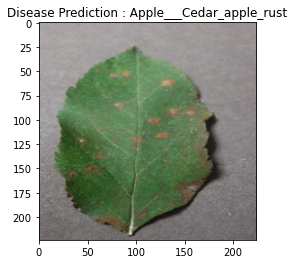

<IPython.core.display.Javascript object>

In [105]:
single_prediction("test_images/Apple_ceder_apple_rust.JPG")

### Wrong Prediction

Original :  Apple_scab


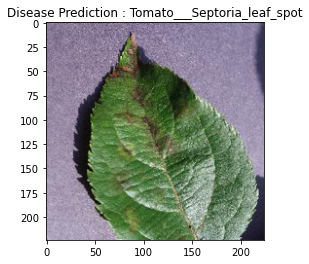

<IPython.core.display.Javascript object>

In [106]:
single_prediction("test_images/Apple_scab.JPG")

Original :  Grape_esca


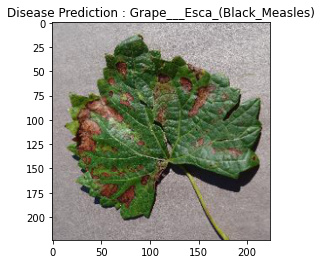

<IPython.core.display.Javascript object>

In [107]:
single_prediction("test_images/Grape_esca.JPG")

Original :  apple_black_rot


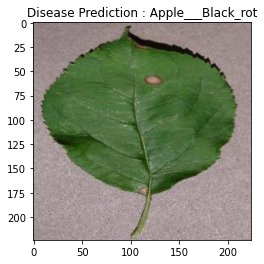

<IPython.core.display.Javascript object>

In [108]:
single_prediction("test_images/apple_black_rot.JPG")

Original :  apple_healthy


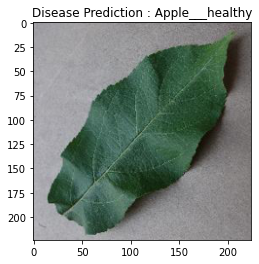

<IPython.core.display.Javascript object>

In [109]:
single_prediction("test_images/apple_healthy.JPG")

Original :  background_without_leaves


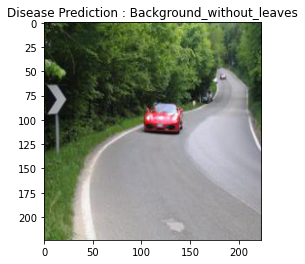

<IPython.core.display.Javascript object>

In [110]:
single_prediction("test_images/background_without_leaves.jpg")

Original :  blueberry_healthy


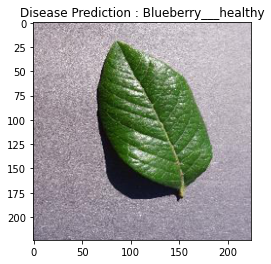

<IPython.core.display.Javascript object>

In [111]:
single_prediction("test_images/blueberry_healthy.JPG")

Original :  cherry_healthy


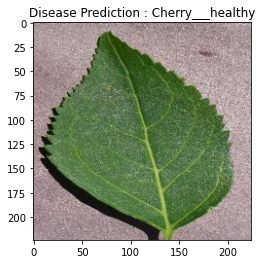

<IPython.core.display.Javascript object>

In [112]:
single_prediction("test_images/cherry_healthy.JPG")

Original :  cherry_powdery_mildew


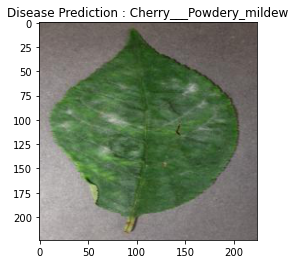

<IPython.core.display.Javascript object>

In [113]:
single_prediction("test_images/cherry_powdery_mildew.JPG")

Original :  corn_cercospora_leaf


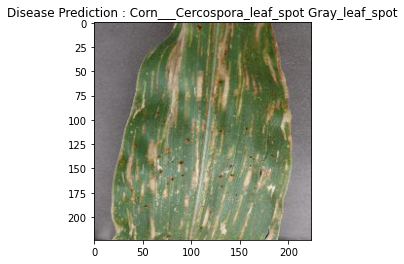

<IPython.core.display.Javascript object>

In [114]:
single_prediction("test_images/corn_cercospora_leaf.JPG")

Original :  corn_common_rust


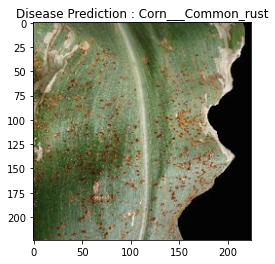

<IPython.core.display.Javascript object>

In [115]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_healthy


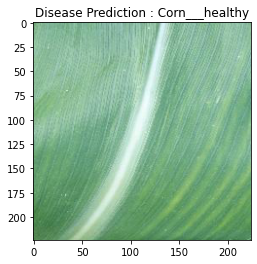

<IPython.core.display.Javascript object>

In [116]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_northen_leaf_blight


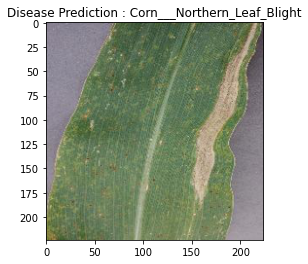

<IPython.core.display.Javascript object>

In [117]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  grape_black_rot


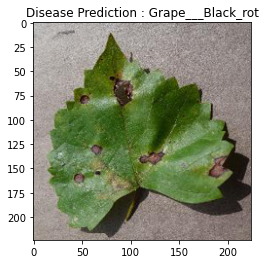

<IPython.core.display.Javascript object>

In [118]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_healthy


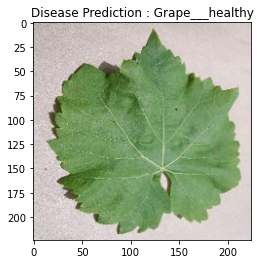

<IPython.core.display.Javascript object>

In [119]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_leaf_blight


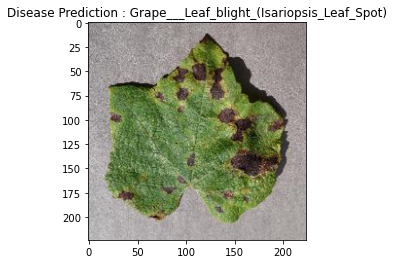

<IPython.core.display.Javascript object>

In [120]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  orange_haunglongbing


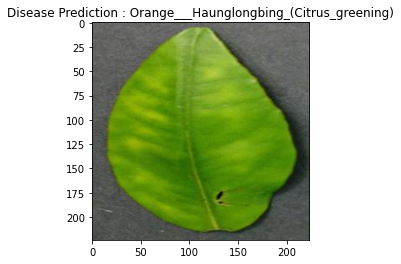

<IPython.core.display.Javascript object>

In [121]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  peach_bacterial_spot


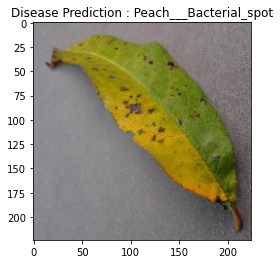

<IPython.core.display.Javascript object>

In [122]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_healthy


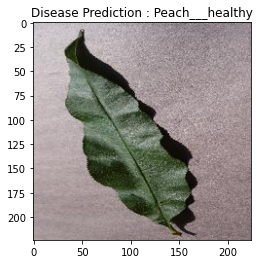

<IPython.core.display.Javascript object>

In [123]:
single_prediction("test_images/peach_healthy.JPG")

Original :  pepper_bacterial_spot


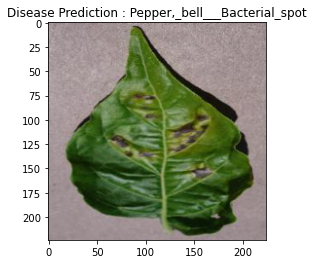

<IPython.core.display.Javascript object>

In [124]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bell_healthy


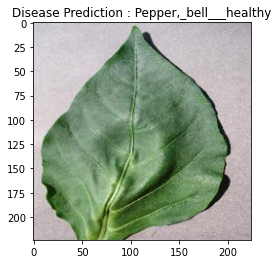

<IPython.core.display.Javascript object>

In [125]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  potato_early_blight


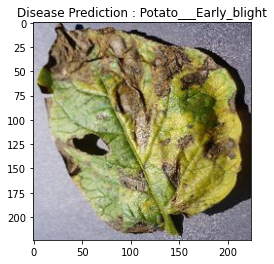

<IPython.core.display.Javascript object>

In [126]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_healthy


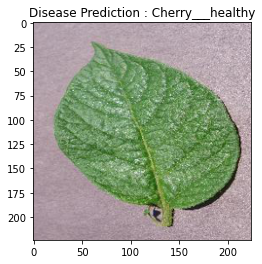

<IPython.core.display.Javascript object>

In [127]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_late_blight


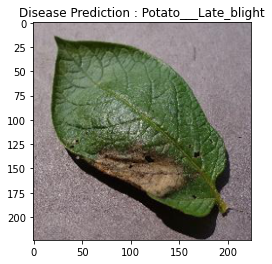

<IPython.core.display.Javascript object>

In [128]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  raspberry_healthy


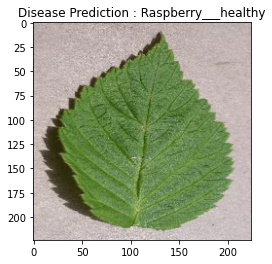

<IPython.core.display.Javascript object>

In [129]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  soyaben healthy


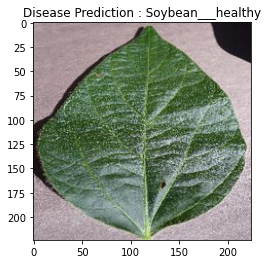

<IPython.core.display.Javascript object>

In [130]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  potato_late_blight


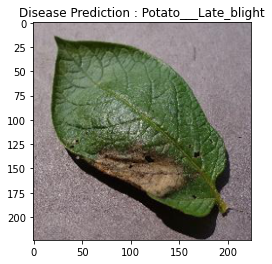

<IPython.core.display.Javascript object>

In [131]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  squash_powdery_mildew


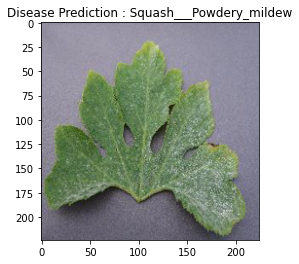

<IPython.core.display.Javascript object>

In [132]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  starwberry_healthy


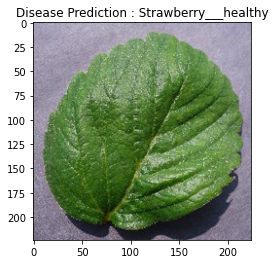

<IPython.core.display.Javascript object>

In [133]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_leaf_scorch


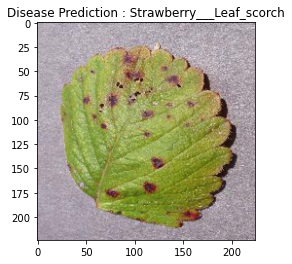

<IPython.core.display.Javascript object>

In [134]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  tomato_bacterial_spot


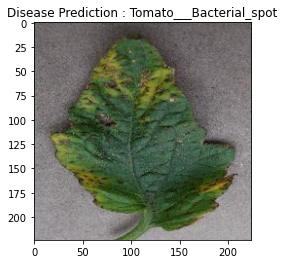

<IPython.core.display.Javascript object>

In [135]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_early_blight


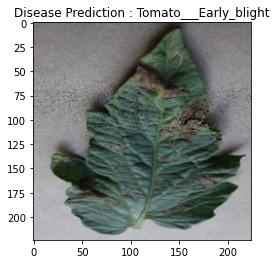

<IPython.core.display.Javascript object>

In [136]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_healthy


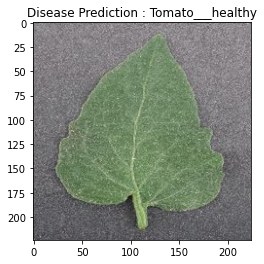

<IPython.core.display.Javascript object>

In [137]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_late_blight


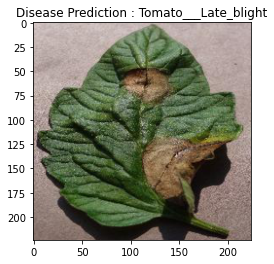

<IPython.core.display.Javascript object>

In [138]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_leaf_mold


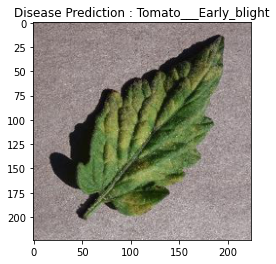

<IPython.core.display.Javascript object>

In [139]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_mosaic_virus


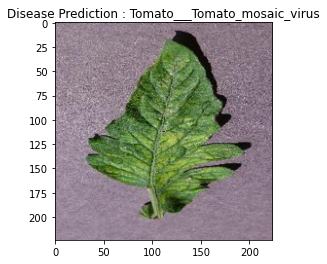

<IPython.core.display.Javascript object>

In [140]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_septoria_leaf_spot


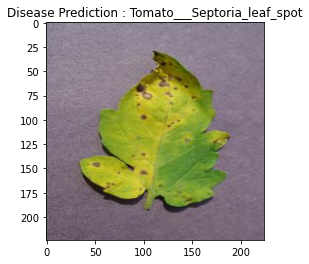

<IPython.core.display.Javascript object>

In [141]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites


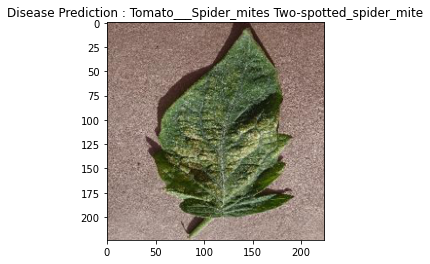

<IPython.core.display.Javascript object>

In [142]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_target_spot


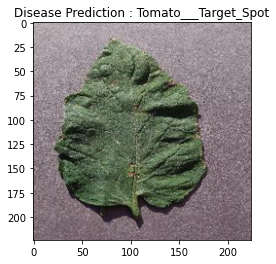

<IPython.core.display.Javascript object>

In [143]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_yellow_leaf_curl_virus


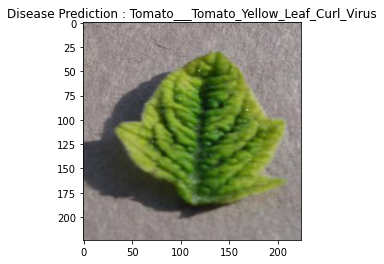

<IPython.core.display.Javascript object>

In [144]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

### Image Outside of Dataset

Original :  


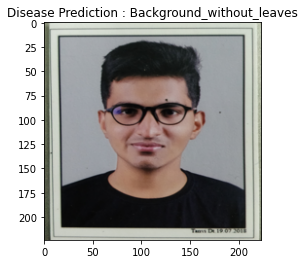

<IPython.core.display.Javascript object>

In [145]:
single_prediction("PHOTO.jpg")

Original :  tomato_yellow_leaf_curl_virus2


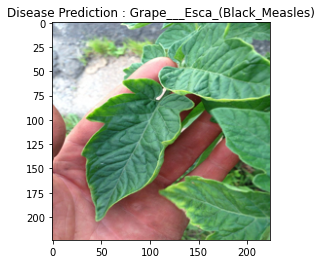

<IPython.core.display.Javascript object>

In [146]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus2.jpg")

Original :  tomato-leaf-curl-virus3


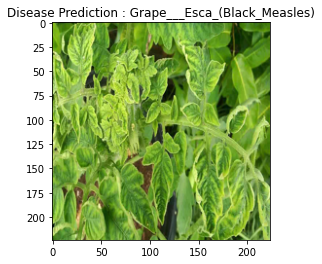

<IPython.core.display.Javascript object>

In [147]:
single_prediction("test_images/tomato-leaf-curl-virus3.jpg")

Original :  tomato-bacterial-spot2


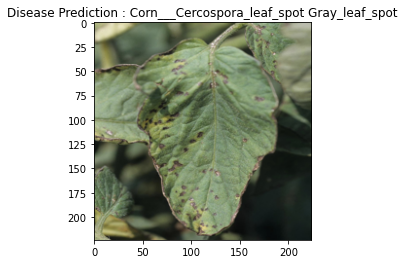

<IPython.core.display.Javascript object>

In [148]:
single_prediction("test_images/tomato-bacterial-spot2.jpg")

Original :  tomato-mold


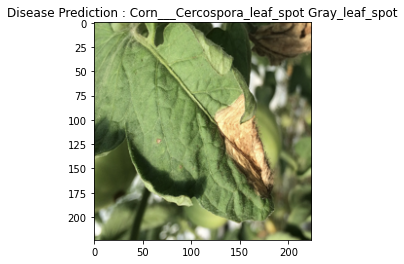

<IPython.core.display.Javascript object>

In [149]:
single_prediction("test_images/tomato-mold.jpg")